In [1]:
import pandas as pd
import os
import json
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import config as cg_config

## 1 . Load the whole graph
#### (No analysis here, can be skipped over)

In [2]:
import csv
import os
import json
import random
import networkx as nx
import numpy as np
import config as cg_config


class cooc_edge_dict(dict):
    def __hash__(self):
            return hash(tuple(sorted(self['edge'])))


def _load_node_tuples(with_contexts=False, entities_only=False):
    """ loads nodes as (<id>, <properties>) tuples
    """

    entity_tuples = []
    # first all regularly stored entities
    node_fns = [
        cg_config.graph_meths_fn,
        cg_config.graph_dsets_fn,
        cg_config.graph_tasks_fn,
        cg_config.graph_modls_fn,
    ]
    if not entities_only:
        node_fns.append(cg_config.graph_pprs_fn)
    if with_contexts:
        node_fns.append(cg_config.graph_cntxts_fn)
    for fn in node_fns:
        with open(os.path.join(cg_config.graph_data_dir, fn)) as f:
            for line in f:
                entity = json.loads(line)
                entity_tuples.append((entity['id'], entity))
    # then some special processing for the areas to collections data
    with open(os.path.join(
        cg_config.graph_data_dir,
        cg_config.graph_meth_areas_fn
    )) as f:
        if entities_only:
            pass
        for line in f:
            # area
            area = json.loads(line)
            entity_tuples.append((
                area['id'],
                {
                    'id': area['id'],
                    'type': area['type'],
                    'name': area['name']
                }
            ))
            # all contained collections
            for coll in area['collections']:
                entity_tuples.append(
                    (coll['id'], coll)
                )
    return entity_tuples


def _load_edge_tuples(with_contexts=False, final_node_set=False):
    """ loads edges as (<id>, <properties>) tuples

        If final_node_set is given, only edges between existing nodes
        will be returned.
    """

    # first all regularly stored edges
    edge_types = [
        # used_in_paper
        [cg_config.graph_meths_to_pprs_fn, 'used_in_paper'],
        [cg_config.graph_dsets_to_pprs_fn, 'used_in_paper'],
        [cg_config.graph_tasks_to_pprs_fn, 'used_in_paper'],
        [cg_config.graph_modls_to_pprs_fn, 'used_in_paper'],
        # evaluated on
        [cg_config.graph_meths_to_dsets_fn, 'evaluated_on'],
        # # ^ NOTE: this means method used for (some task) on dataset
        # #         as extracted from evaltable
        # #         TODO: - mby also establish link between method and task
        # #               - or think of a "eval set" (meth, dset, task)
        # #               - should be associated w/ a date to prune graph of
        # #                 future
        # has task
        [cg_config.graph_dsets_to_tasks_fn, 'has_task'],
        # has subtask
        [cg_config.graph_tasks_to_subtasks_fn, 'has_subtask'],
        # # ^ could be reversed and given type 'part_of'
        # cites
        [cg_config.graph_ppr_to_ppr_fn, 'cites'],
        # part_of
        [cg_config.graph_meths_to_colls_fn, 'part_of']
        # (further down also: collection to area
        #                     entity     to context (if param set)
        #                     context    to paper)
    ]
    edge_tuples = []
    for (fn, edge_type) in edge_types:
        header_idxs = [0, 1]
        if edge_type == 'cites':
            header_idxs = [3, 4]
        with open(os.path.join(cg_config.graph_data_dir, fn)) as f:
            csv_reader = csv.DictReader(
                f,
                delimiter=',',
                quoting=csv.QUOTE_NONE
            )
            headers = csv_reader.fieldnames
            for row in csv_reader:
                tail_id = row[headers[header_idxs[0]]]
                head_id = row[headers[header_idxs[1]]]
                if final_node_set is False or (
                        tail_id in final_node_set and
                        head_id in final_node_set
                        ):
                    edge_tuples.append(
                        (
                            tail_id,
                            head_id,
                            {'type': edge_type}
                        )
                    )
    # then some special processing for the areas to collections data
    with open(os.path.join(
        cg_config.graph_data_dir,
        cg_config.graph_meth_areas_fn
    )) as f:
        for line in f:
            area = json.loads(line)
            head_id = area['id']
            for coll in area['collections']:
                tail_id = coll['id']
                if final_node_set is False or (
                        tail_id in final_node_set and
                        head_id in final_node_set
                        ):
                    edge_tuples.append(
                        (
                            tail_id,
                            head_id,
                            {'type': 'part_of'}
                        )
                    )

    if with_contexts:
        # lastly some special processing for contexts to papers and entities
        with open(os.path.join(
            cg_config.graph_data_dir,
            cg_config.graph_cntxts_fn
        )) as f:
            for line in f:
                cntxt = json.loads(line)
                # entity to context
                tail_id = cntxt['entity_id']
                head_id = cntxt['id']
                if final_node_set is False or (
                        tail_id in final_node_set and
                        head_id in final_node_set
                        ):
                    edge_tuples.append(
                        (
                            tail_id,
                            head_id,
                            {'type': 'part_of'}
                        )
                    )
                # context to paper
                tail_id = cntxt['id']
                head_id = cntxt['paper_pwc_id']
                if final_node_set is False or (
                        tail_id in final_node_set and
                        head_id in final_node_set
                        ):
                    edge_tuples.append(
                        (
                            tail_id,
                            head_id,
                            {'type': 'part_of'}
                        )
                    )
    return edge_tuples


def _get_entity_coocurrence_edges(G, lim=-1):
    """ Determine pairs of entities (of dissimilar type) which
        are used in at least one common paper.

        To make subsequent processing steps more efficient,
        also determine all common papers for each entity
        pair as well as the earliest year in which any of those
        papers was published.
    """

    cooc_edges = dict()
    # get an undirected view to be able
    # to go from papers to used enitites
    uG = G.to_undirected(as_view=True)
    # for all papers
    lim_reached = False
    for (ppr_id, ppr_data) in uG.nodes(data=True):
        if lim_reached:
            break
        if 'type' not in ppr_data:
            # nodes without any data get created by
            # adding edges to inexistent nodes
            continue
        if ppr_data['type'] != 'paper':
            continue
        ppr_used_entities = set()
        # for all their used entities
        for (entity_id, edge_data) in uG.adj[ppr_id].items():
            if edge_data['type'] != 'used_in_paper':
                continue
            ppr_used_entities.add(entity_id)
        # get pairs of entities of dissimilar type
        for e1_id in ppr_used_entities:
            if lim_reached:
                break
            e1 = G.nodes[e1_id]
            for e2_id in ppr_used_entities:
                if lim_reached:
                    break
                e2 = G.nodes[e2_id]
                # only need to check for dissimilar node type
                # ⇣ because dissimilar ID logically follows
                if e1['type'] != e2['type'] and \
                        not (e1['type'] == 'model' and e2['type'] == 'method'):
                    key = '_'.join(sorted([e1_id, e2_id]))
                    if key not in cooc_edges:
                        cooc_edges[key] = cooc_edge_dict({
                            'edge': [e1_id, e2_id],
                            'cooc_pprs': set([ppr_id]),
                            'cooc_start_year': ppr_data['year'],
                            'cooc_start_month': ppr_data['month']
                        })
                    else:
                        cooc_edges[key]['cooc_pprs'].add(
                            ppr_id
                        )
                        cooc_edges[key]['cooc_start_year'] = min(
                            ppr_data['year'],
                            cooc_edges[key]['cooc_start_year']
                        )
                        cooc_edges[key]['cooc_start_month'] = min(
                            ppr_data['year'],
                            cooc_edges[key]['cooc_start_month']
                        )
                    if lim > 0 and len(cooc_edges) >= lim:
                        lim_reached = True

    return cooc_edges  # 2M edges if lim is not set


def _get_two_hop_pair_neighborhood_nodes(cooc_entity_pair, G):
    """ Get two hop neighborhood for a pair of entities
        that co-occur in at least one paper.
    """

    # TODO: generalize to n hops

    keep_node_ids = set()

    # get an undirected view to be able
    # to go from papers to used enitites
    uG = G.to_undirected(as_view=True)

    # for both entities
    for entity in cooc_entity_pair['edge']:
        # first hop neighborhood
        for one_hop_neigh in uG.neighbors(entity):
            keep_node_ids.add(one_hop_neigh)
            # second hop neighborhood
            for two_hop_neigh in uG.neighbors(one_hop_neigh):
                keep_node_ids.add(two_hop_neigh)
    return G.subgraph(keep_node_ids)


def _get_pruned_graph(cooc_entity_pair, G):
    """ For a pair of entities that co-occur in at least one paper
        (given as a dictionary containing the entities and a list of
        all co-occurrence papers)
        return a pruned version of the graph G that contains only
        papers before the first co-occurrence paper.
    """

    # TODO: currently takes 4 seconds on full graph -> too long?
    #       (takes 126 ms on an edge’s two hop neighborhood)

    keep_node_ids = []

    # determine all papers published after earliest cooc ppr
    for node_id in G.nodes:
        node_data = G.nodes[node_id]
        if len(node_data) > 0:
            if node_data['type'] != 'paper':
                # not a paper, keep
                # (TODO: also consider other enitites
                #  that should be removed)
                keep_node_ids.append(node_id)
            elif node_data['year'] < cooc_entity_pair['cooc_start_year'] and \
                    node_data['month'] < cooc_entity_pair['cooc_start_month']:
                # a paper but published early enough
                keep_node_ids.append(node_id)

    return G.subgraph(keep_node_ids)


def _corrupted_cooc_eges(e1, e2, G):
    """ Return corrupted co-occurrence edges by
        swapping tail nodes.

        Assumes that
            - earliest co-occurrence paper of e1 and e1
              were published in the same year.
            - sets co-occurrence papers of e1 and e1 are
              disjoint.
    """

    shared_cooc_start_year = e1['cooc_start_year']
    # the start month of negative samples has a *LARGE*
    # impact on the resulting size of pruned graphs,
    # as many papers are published in a short time.
    # tried
    # - default 1 -> neg smpl graphs way smaller
    # - default 6 -> "
    # - for each corrupted edge take the
    #   month of the entity which is more
    #   connected -> "
    # - same as above but never
    #   less than 7 -> looks about right
    # - default 12 -> neg smpl graphs somewhat larger
    # (clustering by year and month beforehand leads
    #  to average cluster sizes of mean ~2.9 and
    #  median 2 => swapping partners are not really
    #  random anymore but determined by publishing month
    #  => likely underirable)
    corr1_edge = [e1['edge'][0], e2['edge'][1]]
    if len(G.adj[e1['edge'][0]]) > len(G.adj[e2['edge'][1]]):
        corr1_month = e1['cooc_start_month']
    else:
        corr1_month = e2['cooc_start_month']
    corr1 = cooc_edge_dict({
        'edge': corr1_edge,
        'cooc_pprs': set(),  # empty
        'cooc_start_year': shared_cooc_start_year,
        'cooc_start_month': max(corr1_month, 7),
    })
    corr2_edge = [e2['edge'][0], e1['edge'][1]]
    if len(G.adj[e2['edge'][0]]) > len(G.adj[e1['edge'][1]]):
        corr2_month = e2['cooc_start_month']
    else:
        corr2_month = e1['cooc_start_month']
    corr2 = cooc_edge_dict({
        'edge': corr2_edge,
        'cooc_pprs': set(),  # empty
        'cooc_start_year': shared_cooc_start_year,
        'cooc_start_month': max(corr2_month, 7),
    })
    return [corr1, corr2]


def get_pair_graphs(n_true_pairs, G):
    """ Return 2 × n_true_pairs graphs with their respective prediction edge.
            - half are *prunded* graphs of co-occurring entities
            - the other half are *prunded* graphs of non-co-occurring entities

        A pair of co-occurring entities are two differently typed entities
        which have at least one common paper in which they are used.
    """

    # get positive training examples
    # # don’t apply limit here                          |
    # # b/c it’s fast enough to do the whole graph      V
    cooc_edges_full = _get_entity_coocurrence_edges(G, -1)
    # generate negative training examples
    # # cluster co-occurrence edges by year of earliest cooc ppr
    edge_year_clusters = dict()
    for key, cooc_edge in cooc_edges_full.items():
        # only use year here and not also month
        if cooc_edge['cooc_start_year'] not in edge_year_clusters:
            edge_year_clusters[cooc_edge['cooc_start_year']] = []
        edge_year_clusters[cooc_edge['cooc_start_year']].append(
            cooc_edge
        )
    # # generate corrupted co-occurrence edges by swapping entities
    # # between edges in the same co-occurrence year cluster that
    # # have disjoint co-occurrence paper sets
    num_cooc_edges_full = sum([len(l) for k, l in edge_year_clusters.items()])
    year_smpl_sizes = dict()
    for cooc_start_year, cooc_edge_list in edge_year_clusters.items():
        # determine co-occurrence year cluter characteristics
        proportion = len(cooc_edge_list)/num_cooc_edges_full
        if n_true_pairs > 0:
            sample_size = round(n_true_pairs * proportion)
        else:
            sample_size = round(len(cooc_edge_list) * proportion)
        year_smpl_sizes[cooc_start_year] = sample_size
    if n_true_pairs > 0:
        # # make sure year samples add up to n_true_pairs
        smpl_diff = n_true_pairs - sum(year_smpl_sizes.values())
        fill_year = list(year_smpl_sizes.keys())[
            np.argmax(year_smpl_sizes.values())
        ]
        year_smpl_sizes[fill_year] += smpl_diff
    # # sample positive and negative prediction edges
    cooc_edges_pos = set()
    cooc_edges_neg = set()
    for cooc_start_year, cooc_edge_list in edge_year_clusters.items():
        sample_size = year_smpl_sizes[cooc_start_year]
        if sample_size < 1:
            continue
        # create negative samples
        shuf1 = random.sample(cooc_edge_list, len(cooc_edge_list))
        shuf2 = random.sample(cooc_edge_list, len(cooc_edge_list))
        size_reached = False
        year_smpl_pos = set()
        year_smpl_neg = set()
        for cooc_edge1 in shuf1:
            if size_reached:
                break
            for cooc_edge2 in shuf2:
                if len(year_smpl_pos) >= sample_size and \
                   len(year_smpl_neg) >= sample_size:
                    size_reached = True
                if len(set.intersection(
                    cooc_edge1['cooc_pprs'],
                    cooc_edge2['cooc_pprs']
                )) == 0:
                    # true prediction edges
                    year_smpl_pos.add(cooc_edge1)
                    year_smpl_pos.add(cooc_edge2)
                    # false prediction edges
                    corr1, corr2 = _corrupted_cooc_eges(
                        cooc_edge1, cooc_edge2, G
                    )
                    year_smpl_neg.add(corr1)
                    year_smpl_neg.add(corr2)
        # cut year’s contribution to full sample to size
        cooc_edges_pos.update(
            random.sample(
                year_smpl_pos,
                min(sample_size, len(year_smpl_pos))
                )
        )
        cooc_edges_neg.update(
            random.sample(
                year_smpl_neg,
                min(sample_size, len(year_smpl_neg))
                )
        )
    # create graphs
    true_pair_grahps = []
    false_pair_grahps = []
    for graph_list, edge_list in [
        (true_pair_grahps, cooc_edges_pos),
        (false_pair_grahps, cooc_edges_neg)
    ]:
        for cooc_edge in edge_list:
            # reduce to neighborhood that is potentially necessary (speedup)
            neigh_G = _get_two_hop_pair_neighborhood_nodes(cooc_edge, G)
            # remove paper nodes based on time constraint
            pruned_G = _get_pruned_graph(cooc_edge, neigh_G)
            # reduce to neighborhood (gets rid of stuff that is onyl
            # connected in unpruned graph)
            pruned_neigh_G = _get_two_hop_pair_neighborhood_nodes(
                cooc_edge,
                pruned_G
            )
            graph_list.append({
                'prediction_edge': cooc_edge,
                'graph': pruned_neigh_G
            })
    # test for n_true_pairs = 200:
    #
    # In [204]: np.mean([len(x['graph'].nodes) for x in fls])
    # Out[204]: 134.485
    # In [205]: np.mean([len(x['graph'].nodes) for x in tru])
    # Out[205]: 2742.075
    # -> why fewer nodes for negative edges?
    # TODO: debug
    #
    # In [202]: np.mean([len(x['graph'].edges) for x in fls])
    # Out[202]: 193.685
    # In [203]: np.mean([len(x['graph'].edges) for x in tru])
    # Out[203]: 17480.44
    return true_pair_grahps, false_pair_grahps


def make_shallow(G):
    """ Remove all attributes except for type from nodes and edges
    """

    if type(G) == nx.DiGraph:
        shallow_G = nx.DiGraph()
    else:
        shallow_G = nx.Graph()

    for nid, ndata in G.nodes.items():
        shallow_G.add_nodes_from([(nid, {'type': ndata['type']})])
    for edge_tuple, edata in G.edges.items():
        naid, nbid = edge_tuple
        shallow_G.add_edges_from([(naid, nbid, {'type': edata['type']})])

    return shallow_G


def _load_entity_combi_edge_tuples(final_node_set=False, scheme='sequence'):
    """ Determine edges tuples that represent the
        number of co-occurrence papers between entities.

        schemes:
            - sequence: time sequence of co-occurences
            - weight: number of co-occurences
    """

    # not the most time efficient, but simply
    # go from the full graph using existing code
    G = load_full_graph()
    cooc_edges_full = _get_entity_coocurrence_edges(G, -1)
    # create combi edges
    edge_tuples = []
    # determine earliest cooc ppr in current data is from 1994
    cooc_years = []
    for k, ce in cooc_edges_full.items():
        cooc_years.append(ce['cooc_start_year'])
    beginning_of_time = min(cooc_years)
    for key, cooc_edge in cooc_edges_full.items():
        ppr_a_id = cooc_edge['edge'][0]
        ppr_b_id = cooc_edge['edge'][1]
        if scheme == 'sequence':
            # build co-occurence time sequence
            cooc_time_sequence = []
            cooc_ppr_sequence = []
            for ppr_id in cooc_edge['cooc_pprs']:
                y = G.nodes[ppr_id]['year']
                m = G.nodes[ppr_id]['month']
                # there is also day info, but mby not so relevant
                if y > 0 and m > 0:  # is -1 if info not given
                    year_in_cooc_time = y - beginning_of_time
                    month_in_cooc_time = (year_in_cooc_time * 12) + m
                    cooc_time_sequence.append(month_in_cooc_time)
                    cooc_ppr_sequence.append(ppr_id)
            edge_property = {
                'interaction_sequence': cooc_time_sequence,
                'linker_sequence': cooc_ppr_sequence
            }
        elif scheme == 'weight':
            # TODO:
            # consider then using add_weighted_edges_from later
            edge_property = {'weight': len(cooc_edge['cooc_pprs'])}
        if not final_node_set or \
                (final_node_set and
                 ppr_a_id in final_node_set and
                 ppr_b_id in final_node_set):
            edge_tuples.append(
                (
                    ppr_a_id,
                    ppr_b_id,
                    edge_property
                )
            )
    return edge_tuples


def load_entity_combi_graph():
    """ Load graph only containing the entity nodes,
        connected by weighted edges that represent the
        number of co-occurrence papers.

        NOTE: to access edge attributes later,
               G.edges(data=True) has to be used!
    """

    node_tuples = _load_node_tuples(entities_only=True)
    edge_tuples = _load_entity_combi_edge_tuples(
        # make sure not to give networkx a reason to implicitly
        # add empty, untyped nodes because of edges
        final_node_set=set([ntup[0] for ntup in node_tuples])
    )
    G = nx.Graph()
    G.add_nodes_from(node_tuples)
    G.add_edges_from(edge_tuples)
    return G


def load_full_graph(shallow=False, directed=True, with_contexts=False):
    """ Load nodes and edges into a NetworkX digraph.

        If shallow is True, all node and edge features
        except for type will be discarded.
    """

    node_tuples = _load_node_tuples(
        with_contexts=with_contexts
    )
    edge_tuples = _load_edge_tuples(
        with_contexts=with_contexts,
        # make sure not to give networkx a reason to implicitly
        # add empty, untyped nodes because of edges
        final_node_set=set([ntup[0] for ntup in node_tuples])
    )
    if shallow:
        shallow_node_tuples = []
        shallow_edge_tuples = []
        for n in node_tuples:
            shallow_node_tuples.append((
                n[0],
                {'type': n[1]['type']}
            ))
        for e in edge_tuples:
            shallow_edge_tuples.append((
                e[0],
                e[1],
                {'type': e[2]['type']}
            ))
        node_tuples = shallow_node_tuples
        edge_tuples = shallow_edge_tuples
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    G.add_nodes_from(node_tuples)
    G.add_edges_from(edge_tuples)
    return G



In [3]:
G = load_full_graph()

In [4]:
len(G.nodes)

284760

## 2. statistical anaylsis for the whole and atom graphs

### 2.1 num analysis

In [5]:
types = []
for i in G.nodes(data=True):
    try:
        type_ = i[0].split(":")[1].split("/")[0]
    except:
        type_ = None
    types.append(type_)

df_types = pd.DataFrame(types)
df_types.value_counts()

paper         260382
model          14581
dataset         5109
task            2534
method          1802
collection       345
area               7
dtype: int64

In [36]:
# total number of entities
df_types.value_counts().sum()

284760

In [35]:
# percentage of "paper"
df_types.value_counts()[0]/df_types.value_counts().sum()

0.9143910661609777

In [6]:
# existing edges / possible edges
#nx.density(G)
#nx.connected_components(G)
#nx.transitivity(G)

### 2.2 degree

#### 2.2.1 Whole graph

In [7]:
df_degree = pd.DataFrame(G.degree(), columns=["nodes", "degree"])

In [8]:
df_degree.head(3)

,nodes,degree
0,pwc:method/densenas-a,3
1,pwc:method/fast-voxel-query,2
2,pwc:method/segregated-attention-network,2


In [38]:
# average degree of the whole graph
np.mean(df_degree.degree)

8.102345835089197

In [9]:
# "classification" has the most edges
print(df_degree["degree"].idxmax())
print(df_degree.iloc[7735,:])

7735
nodes     pwc:task/classification
degree                      14523
Name: 7735, dtype: object


In [10]:
# About 98.67% of all nodes have a degree less than the threshold 50
threshold = 50
lg = df_degree["degree"].value_counts().index < threshold
df_degree["degree"].value_counts()[lg].sum() / len(G.nodes)

0.9866624525916561

<AxesSubplot:title={'center':'kernel density of node degrees in the whole graph'}, xlabel='degree', ylabel='Density'>

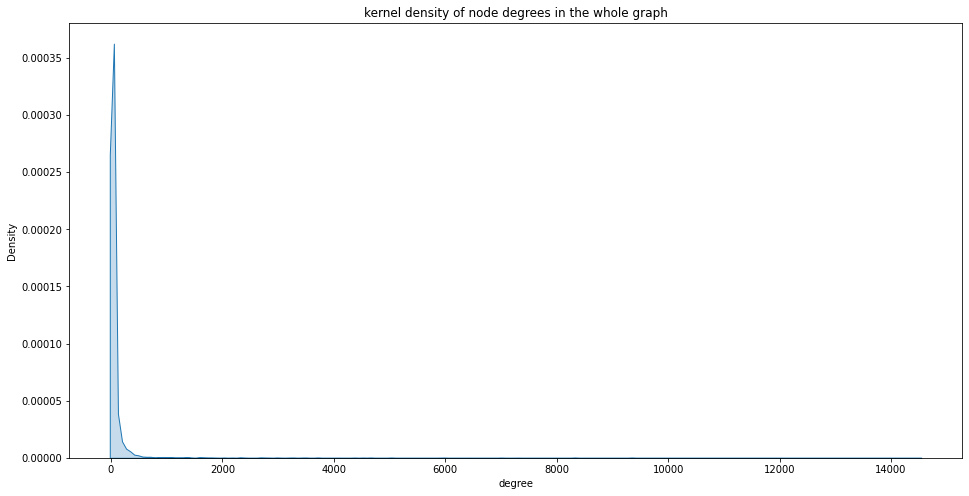

In [11]:
# kdeplot of degrees
plt.figure(figsize=(16, 8))
plt.title("kernel density of node degrees in the whole graph")
sns.kdeplot(df_degree["degree"], fill=True)

In [12]:
df_degree_type = df_degree.copy()
df_degree_type["nodes"] = df_degree["nodes"].apply(lambda x: x.split(":")[1].split("/")[0])

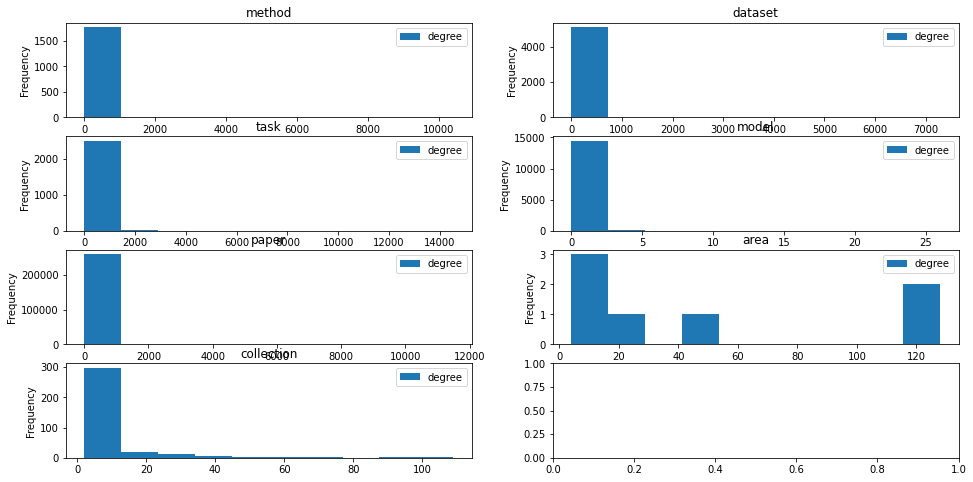

In [13]:
# draw histplot of "degree" of all types of entities
f, ax = plt.subplots(4,2, figsize=(20,30))
for i , type_ in enumerate(df_types[0].unique()):
    log = df_degree_type["nodes"]==type_
    degree_type = df_degree_type[log]["degree"]
    axis_i = int(i/2)
    axis_j = 1 if i%2!=0 else 0
    degree_type.reset_index().plot(
        kind="hist", 
        x="index", 
        y="degree", 
        bins=10, 
        ax=ax[axis_i][axis_j], 
        figsize=(16,8), 
        title=type_
    )

- **Analysis on the whole graph level**

1. Over 98% of nodes have degree lower than 50
2. Based on node types, a small portion of "task" has a degree over 1000; for "paper" and "task", the degrees of almost all entities are below 1000; degrees of "dataset" nodes are obviously below 1000; although there is a large amount of "model" type of nodes, their degrees are mostly below 3. ("Area" and "Collection" are ignored)

#### 2.2.2 Atom graphs

In [14]:
def generate_atom_graph(file_dir, file_graph, file_pred, directed=True):

    file_graph_path = os.path.join(file_dir, file_graph)
    file_pred_path = os.path.join(file_dir, file_pred)
    with open(file_graph_path, "r") as g:
        data = json.load(g)
    with open(file_pred_path, "r") as p:
        predicting = json.load(p)
    node_pair_to_predict = predicting["edge"]
    elements = data.get("elements", {})

    nodes = []
    pairs = []
    for node in elements["nodes"]:
        info = node["data"]
        nodes.append((info["id"],
                      {"type": info["type"]}))
    for edge in elements["edges"]:
        structure = edge["data"]
        pairs.append((structure["source"],
                      structure["target"],
                      {"type": structure["type"]}))
    if directed:
        atom_graph = nx.DiGraph()
    else:
        atom_graph = nx.Graph()
    atom_graph.add_nodes_from(nodes)
    atom_graph.add_edges_from(pairs)

    node_names = [node.split(":")[-1].replace("/", "_") for node in node_pair_to_predict]
    final_name = node_names[0] + "-" + node_names[1]
    
    return atom_graph, node_pair_to_predict, final_name


def prepare_samples(num_per_label):
    
    file_pairs = []
    numbers = ["0" + str(i) for i in range(10)] + \
              [str(i) for i in range(10, num_per_label)]
    labels = ["pos", "neg"]

    for num in numbers:
        for l in labels:
            file_graph = "pair_graph_sample_" + l + "_" + num + "_graph.json"
            file_pred = "pair_graph_sample_" + l + "_" + num + \
                        "_prediction_edge.json"
            file_pairs.append((file_graph, file_pred, l))
    return file_pairs

In [15]:
# 5000 for each label as a sampled example
file_pairs = prepare_samples(5000)

In [17]:
df_degrees_avg = pd.DataFrame(columns=["nodes", "graph", "avg_degree_graph", "avg_degree_targets", "label"])
file_dir = "/opt/contextgraph/samples_all"

#for i, file_pair in tqdm(enumerate(file_pairs)):
#    file_graph = file_pair[0]
#    file_pred = file_pair[1]
#    label = file_pair[2]
#    g, target_nodes, node_pair = generate_atom_graph(file_dir, file_graph, file_pred, directed=True)
#    dict_degrees = dict(g.degree())
#    df_degrees_avg.loc[i, "nodes"] = node_pair
#    df_degrees_avg.loc[i, "graph"] = file_graph
#    df_degrees_avg.loc[i, "avg_degree_graph"] = np.mean(list(dict_degrees.values()))
#    df_degrees_avg.loc[i, "avg_degree_targets"] = (dict_degrees.get(target_nodes[0], 0) 
#                                                   + dict_degrees.get(target_nodes[1], 0))/2
#    df_degrees_avg.loc[i, "label"] = label

## final dataframe is store in "/opt/contextgraph"    
#df_degrees_avg.to_csv("samples_all_average_degree_per_graph.csv")

In [31]:
df_degrees_avg= pd.read_csv("/opt/contextgraph/samples_all_average_degree_per_graph.csv", index_col=0)

In [32]:
df_degrees_avg.head(2)

,nodes,graph,avg_degree_graph,avg_degree_targets,label
0,dataset_pathtrack-method_dla,pair_graph_sample_pos_00_graph.json,3.701149,3.5,pos
1,method_roberta-task_video-visual-relation-dete...,pair_graph_sample_neg_00_graph.json,18.480207,50.5,neg


<AxesSubplot:xlabel='avg_degree_graph', ylabel='Count'>

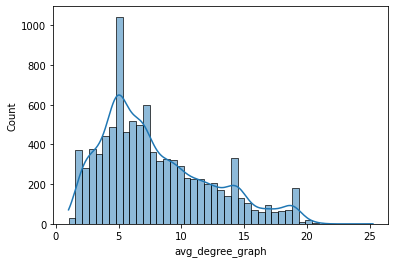

In [20]:
# distribution of average degree of graphs
sns.histplot(df_degrees_avg["avg_degree_graph"], kde=True)

<AxesSubplot:xlabel='avg_degree_targets', ylabel='Density'>

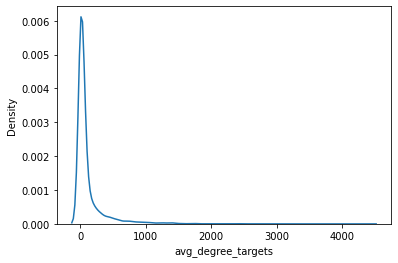

In [21]:
# distribution of average degree of two target nodes
sns.kdeplot(df_degrees_avg["avg_degree_targets"])

In [22]:
# task/classification makes the average degree extremly high
df_degrees_avg[df_degrees_avg["avg_degree_targets"] == df_degrees_avg["avg_degree_targets"].max()]

,nodes,graph,avg_degree_graph,avg_degree_targets,label
3927,task_classification-task_virtual-reality,pair_graph_sample_neg_1963_graph.json,13.88584,4389.0,neg


In [46]:
# samples are well balanced due to the nature of generation process
df_degrees_avg["label"].value_counts()

pos    5000
neg    5000
Name: label, dtype: int64

In [44]:
# compare the average value for pos and neg classes
df_degrees_avg[["avg_degree_graph", "avg_degree_targets", "label"]].groupby("label").mean()

,avg_degree_graph,avg_degree_targets
label,,
neg,7.560554,57.4577
pos,8.276693,179.4095


- Based on the a fraction of all samples that we have:

1. An average degree of 5 of graphs seem to be usual, a small portion of samples has relatively higher average degree, but no higher than 25

2. Entities like "Task/Classification" which has high connnectivity leads to naturally to high average degree of target nodes, but not necessarily to "pos". (Why task and task are generated as target nodes?)

3. While the average degrees of sample graphs have no big difference across positive and negative classes, the average degree of target nodes is significantly higher for positive samples than negative ones, suggesting that positve samples are indeed more "well-connected" (more often combined with other entities)  

4. One problem being found during analysis: Sometime the average degree of two target nodes is lower or euqal than 1 (e.g. 0.5), which means that these two are not even connected with each other, or only connected with each other. (Details are illustrated in Notebook "corrupted graphs") 

----

# 3. realistic test dataset (ratio)

- Idea:
within all the positive examples that we have, find the all possible combination of entities --> treat all non-positive combinations as negtive
- Problem:
Too many negative 

In [23]:
file_pairs = prepare_samples(60000)
node_pair_samples = []
for file_pair in file_pairs:
    file_graph = file_pair[0]
    file_pred = file_pair[1]
    label = file_pair[2]
    file_dir = "/opt/contextgraph/samples_all"
    file_pred_path = os.path.join(file_dir, file_pred)
    with open(file_pred_path, "r") as p:
        predicting = json.load(p)
    node_pair_to_predict = predicting["edge"]
    node_pair_to_predict.append(label)
    node_pair_samples.append(node_pair_to_predict)
    
df_samples = pd.DataFrame(node_pair_samples)
df_samples_types = pd.DataFrame(columns=[0,1,2])

In [24]:
df_samples.head(2)

,0,1,2
0,pwc:dataset/pathtrack,pwc:method/dla,pos
1,pwc:method/roberta,pwc:task/video-visual-relation-detection,neg


In [25]:
get_type = lambda x: x.split(":")[1].split("/")[0]
# df_samples_types[0] = df_samples[0].apply(get_type)
# df_samples_types[1] = df_samples[1].apply(get_type)
# df_samples_types[2] = df_samples[2].map({'pos': 1, 'neg': 0})

# df_samples_types.head(2)

In [26]:
log = df_samples[2] == "pos"
entities_in_pos = set(df_samples[log][0].values + df_samples[log][1].values)
len(entities_in_pos)

60000

In [27]:
types = []
for entity in entities_in_pos:
    types.append(get_type(entity))

num_types = pd.DataFrame(types).value_counts()
num_types

method     21358
task       15995
dataset    15389
model       7258
dtype: int64

In [28]:
# all possible permutations according to the types
all_com = num_types[0] * (num_types[1]+num_types[2]+num_types[3]) + num_types[1]*(num_types[2]+num_types[3]) + (num_types[2]*num_types[3])

In [29]:
all_com

1299247963

In [30]:
# theoratical ratio
# all possible permutations of entites in positive samples
# divided by the number of positive samples
# this ratio should become smaller once we create more positive samples (I suppose)
(all_com-60000)/60000

21653.132716666667